# Analisis de Ciudades

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from wordcloud import WordCloud, STOPWORDS
from difflib import SequenceMatcher

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,23533.0,NaN,NaN,2015-08-23 00:00:00,0.0,0.0,0.0,0.0,0.0,2273000.0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,24514.0,19.310205,-99.227655,2013-06-28 00:00:00,0.0,0.0,0.0,1.0,1.0,3600000.0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,48551.0,NaN,NaN,2015-10-17 00:00:00,0.0,0.0,0.0,0.0,0.0,1200000.0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,53666.0,19.301890,-99.688015,2012-03-09 00:00:00,0.0,0.0,0.0,1.0,1.0,650000.0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,47835.0,NaN,NaN,2016-06-07 00:00:00,0.0,0.0,0.0,0.0,0.0,1150000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng                           116512 non-null float64
fecha                         240

# Asignacion de zonas a las publicaciones

In [4]:
def definir_zona(lat):
    if lat >= 25:
        return 'Norte'
    if lat < 20:
        return 'Sur'
    if 20 < lat < 25:
        return 'Centro'
    return np.nan
    
    

zonas = df.set_index('ciudad')['lat'].transform(definir_zona)
aux = df.loc[:,['ciudad']]
aux['zona'] = df['lat'].transform(definir_zona)
aux['cant'] = 1

df2 = aux.groupby(['ciudad','zona']).agg({'cant':'count'}).reset_index()
df2 = df2[df2.groupby('ciudad')['cant'].transform('max') == df2['cant']].loc[:,['ciudad','zona']].set_index('ciudad')

df_zonas = df2.merge(df, on = 'ciudad', how = 'inner')


In [5]:
def min_threshold(df, threshold):
    '''Funcion para filtrar por una minima cantidad de datos'''
    return df["ciudad"].count() > threshold

#Filtro la informacion a ciudades de mas de 400 propiedades
#df = df.groupby(['ciudad','provincia']).filter(min_threshold, threshold = 2000)
#df['provincia'].value_counts()

In [6]:
df["fecha_publicacion"] = pd.to_datetime(df["fecha"])
df["año_publicacion"] = df["fecha_publicacion"].dt.year
df["mes_publicacion"] = df["fecha_publicacion"].dt.month

In [7]:
fechas = df.groupby(['año_publicacion', 'mes_publicacion']).agg({'mes_publicacion': 'size'})
fechas = fechas.rename(columns = {'mes_publicacion':'publicaciones'})
fechas = fechas.reset_index().pivot(index="año_publicacion", columns = "mes_publicacion", values = "publicaciones")
fechas = fechas.T
for año in fechas.columns:
    fechas[año]/=fechas[año].sum()
fechas

año_publicacion,2012,2013,2014,2015,2016
mes_publicacion,,,,,
1,0.064927,0.065589,0.059228,0.083738,0.061411
2,0.056387,0.046107,0.062457,0.075170,0.048831
3,0.046868,0.057066,0.071872,0.076880,0.053404
4,0.060933,0.060192,0.068520,0.073499,0.070610
5,0.078907,0.065820,0.075693,0.071809,0.057828
6,0.064757,0.066346,0.075964,0.073907,0.072258
7,0.083836,0.083065,0.077024,0.075287,0.063942
8,0.168735,0.078128,0.088312,0.087935,0.068515
9,0.110393,0.109294,0.096397,0.094482,0.063049


## ¿Existe crecimiento anual? ¿Existe alguna epoca del año de mayor flujo de propiedades?

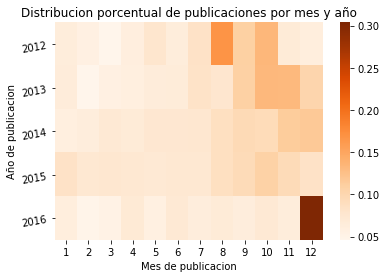

In [8]:
ax = sns.heatmap(fechas.T, cmap="Oranges")
ax.set_yticklabels(ax.get_yticklabels(), rotation=10)
plt.title("Distribucion porcentual de publicaciones por mes y año")
plt.xlabel("Mes de publicacion")
plt.ylabel("Año de publicacion")
ax.set_ylim(5.0, 0)
plt.savefig("figs/heatmap_fechas.png")
plt.show()

# Relacion habitaciones / banos. ¿Que combinacion es comun?

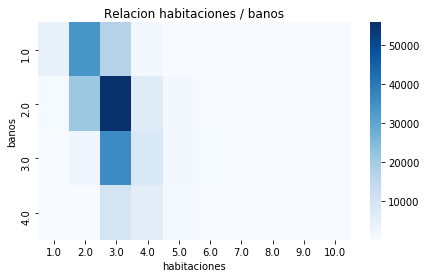

In [9]:
habitaciones_banos = df.groupby(['habitaciones', 'banos']).agg({'id':'count'})
habitaciones_banos.rename(columns = {'id':'cantidad'}, inplace=True)
habitaciones_banos = habitaciones_banos.\
                                        reset_index()\
                                        .pivot(index="habitaciones", columns = "banos", values = "cantidad")

plt.figure(figsize = (7,4))
ax = sns.heatmap(habitaciones_banos.T, cmap="Blues")
ax.set_ylim(4.0, 0)
plt.title('Relacion habitaciones / banos')
plt.savefig('./figs/heatmap_habitaciones_banos.png')
plt.show()

## Ciudades - Antiguedad

In [10]:
antiguedades = df.groupby('ciudad').agg({'antiguedad': 'mean', 'ciudad': 'size'})
antiguedades.rename(columns = {'antiguedad' : 'antiguedad_promedio','ciudad':'cantidad_de_propiedades'}, inplace = True)
antiguedades.sort_values('antiguedad_promedio', ascending = False)
# Antiguedades promedio, ciudades +- viejas

,antiguedad_promedio,cantidad_de_propiedades
ciudad,,
Agua Dulce,80.0,1
Acuitzio,50.0,1
Tepetitlán,36.2,5
Poanas,35.0,1
Acateno,35.0,1
...,...,...
Villanueva,NaN,1
Xicotepec,NaN,1
Yuriria,NaN,1


In [11]:
grandes_ciudades = df.groupby('ciudad').filter(min_threshold, threshold = 7000)
antiguedades_ciudades = grandes_ciudades.groupby(['ciudad', 'antiguedad']).agg({'ciudad':'size'})
antiguedades_ciudades = antiguedades_ciudades.rename(columns = {'ciudad':'cantidades'}).reset_index()
antiguedades_ciudades = antiguedades_ciudades.reset_index().pivot('ciudad', 'antiguedad', 'cantidades')

for antiguedad in antiguedades_ciudades.columns:
    antiguedades_ciudades[antiguedad]/=antiguedades_ciudades[antiguedad].sum()

antiguedades_ciudades = antiguedades_ciudades.T.iloc[:20].T
antiguedades_ciudades

antiguedad,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
ciudad,,,,,,,,,,,,,,,,,,,,
Benito Juárez,0.139381,0.188008,0.225248,0.209741,0.255358,0.300532,0.278481,0.373702,0.280453,0.234899,0.295008,0.173077,0.210526,0.200000,0.160714,0.216000,0.283333,0.260870,0.074074,0.076923
Mérida,0.192475,0.201558,0.116337,0.084053,0.088181,0.070754,0.120253,0.072664,0.076487,0.100671,0.077536,0.230769,0.092105,0.050000,0.071429,0.122667,0.066667,0.043478,0.024691,0.076923
Querétaro,0.311805,0.319106,0.311056,0.386489,0.314146,0.222050,0.343882,0.304498,0.297450,0.308725,0.184280,0.243590,0.355263,0.466667,0.375000,0.240000,0.316667,0.217391,0.345679,0.384615
San Luis Potosí,0.160409,0.141599,0.106436,0.073056,0.075934,0.080027,0.128692,0.093426,0.164306,0.147651,0.071429,0.185897,0.118421,0.066667,0.142857,0.160000,0.133333,0.108696,0.172840,0.192308
Zapopan,0.195930,0.149729,0.240924,0.246661,0.266381,0.326636,0.128692,0.155709,0.181303,0.208054,0.371747,0.166667,0.223684,0.216667,0.250000,0.261333,0.200000,0.369565,0.382716,0.269231


## ¿Son parejas las antiguedades para ciudades en distintas condiciones?

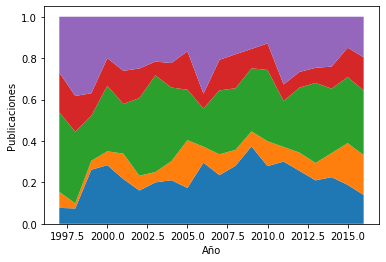

In [12]:
ax = plt.stackplot(list(map(lambda x:2016-x, list(antiguedades_ciudades.columns))),antiguedades_ciudades)
plt.xlabel('Año')
plt.ylabel('Publicaciones')
plt.show()

# Horrible este plot, meu deus

## ¿Existen patrones para cantidad de habitaciones por ciudad?

In [13]:
def obtener_promedio_por_ciudad_de(df, parametro):
    nuevo_df = df.groupby(['ciudad',parametro]).agg({parametro:'size', 'precio':'mean'})
    nuevo_df.rename(columns = {parametro:'cantidad'}, inplace = True)
    cantidades = df.groupby('ciudad').agg({parametro:'sum'})[parametro]
    nuevo_df = nuevo_df.reset_index().set_index('ciudad')
    nuevo_df['totales'] = cantidades
    return nuevo_df

def agrupar_y_aplicar(df, agrupaciones, targets, funciones):
    d = {}
    for target in targets:
        for func in funciones:
            if len(funciones) == 1:
                d[target] = func
            else:
                d[target] = d.get(target, []) + [func]
    return df.groupby(agrupaciones).agg(d)


In [14]:
def filtrar_cantidad(df, cantidad):
    df['cantidad'] = 1
    df2 = df.groupby('provincia').agg({'cantidad':'size'})
    return df.loc[df['provincia'].isin(df2[df2['cantidad'] > cantidad].index)]

def generar_barplot_ciudades(df, nombre):
    plt.figure(figsize=(15, 5))
    serie = setup_barplot_ciudades(df,nombre)
    for provincia in serie['provincia'].unique():
        ax = sns.barplot(x=nombre, y = 'ciudad', data = serie.loc[serie['provincia'] == provincia], palette="Oranges_d")
        plt.title(f'Porcentaje de {nombre} para la provincia {provincia} segun ciudad')
        plt.xlabel('Porcentaje de banos')
        #plt.savefig(f'./figs/{provincia}_porcentaje_{nombre}_por_ciudad.jpg')
        
def setup_barplot_ciudades(df, caracteristica):
    provincias_mas_grandes = filtrar_cantidad(df,7000)
    serie = agrupar_y_aplicar(provincias_mas_grandes, ['provincia','ciudad'], [caracteristica], ['sum']).reset_index()
    serie_provincias = serie.groupby('provincia').agg({caracteristica:'sum'})
    serie.set_index('provincia',inplace=True)
    serie[caracteristica] /= serie_provincias[caracteristica]
    serie[caracteristica] *= 100
    serie = serie.reset_index()
    return serie
        
#generar_barplot_ciudades(df, 'banos')
#generar_barplot_ciudades(df, 'habitaciones')
#generar_barplot_ciudades(df, 'garages')

In [15]:
habitaciones = agrupar_y_aplicar(df, ['ciudad'], ['habitaciones'], ['mean'])#['habitaciones']
habitaciones#.sort_values(ascending = False).head(10)

,habitaciones
ciudad,
Abalá,NaN
Abasolo,4.000000
Abejones,3.000000
Acajete,2.833333
Acambay,2.875000
...,...
ácatlán de Juárez,NaN
ácaxochitlán,3.250000
ácámbaro,3.000000


In [16]:
garages = agrupar_y_aplicar(df, ['ciudad'], ['garages'], ['mean'])['garages']
garages.sort_values(ascending = False).head(10)

ciudad
Chignautla                3.0
Chalchicomula de Sesma    3.0
Ixtlán                    3.0
Ixhuatlancillo            3.0
Totoltepec de Guerrero    3.0
Ucú                       3.0
Tetela del Volcán         3.0
Tihuatlán                 3.0
Dzitás                    3.0
Cerro Azul                3.0
Name: garages, dtype: float64

## La cercania a un centro comercial tiene un impacto positivo en el precio de una propiedad para cualquier ciudad

In [17]:
precios_promedio_por_ciudad = df.groupby('ciudad').agg({'precio':'mean'})
precios_promedio_por_ciudad_con_comercio = df[df['centroscomercialescercanos'] == 1].groupby('ciudad').agg({'precio':'mean'})

## ¿Es el nivel de oferta una variable que afecte al valor del metro cuadrado cubierto?

Text(0, 0.5, 'Cantidad de publicaciones del mes')

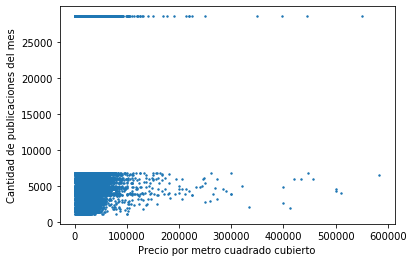

In [18]:
plt.scatter(df['precio']/df['metroscubiertos'], df.groupby(['mes_publicacion', 'año_publicacion'])['mes_publicacion'].transform('count'), s=2)
plt.xlabel('Precio por metro cuadrado cubierto')
plt.ylabel('Cantidad de publicaciones del mes')

In [19]:
sin_diciembre = df.loc[lambda x:(x['año_publicacion'] != 2016) | (x['mes_publicacion'] != 12), ['mes_publicacion','año_publicacion','zona','precio','metroscubiertos']]

c:\users\juani\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


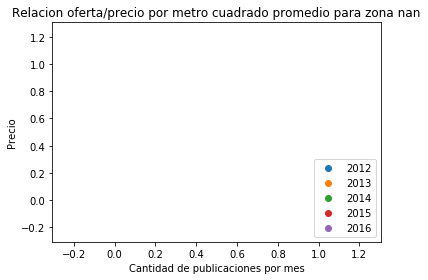

In [20]:
def generar_scatter(df,zona):
    #plt.figure(figsize = (16,6))
    for año in range(2012,2017):
        nuevo_df = pd.DataFrame()
        info = df.loc[lambda x:(x['año_publicacion'] == año)]\
                                            .groupby(['mes_publicacion','año_publicacion'])
        info = info.agg({'precio':'sum', 'metroscubiertos':'sum', 'mes_publicacion':'count'})
        plt.scatter(info['mes_publicacion'],info['precio']/info['metroscubiertos'], label = año)
        plt.ylabel('Precio')
        plt.xlabel('Cantidad de publicaciones por mes')
        plt.title(f'Relacion oferta/precio por metro cuadrado promedio para zona {zona}')
        plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.savefig(f'./figs/scatter_oferta_precio_zona_{zona}.jpg')
    


#generar_scatter(sin_diciembre)
for zona in sin_diciembre['zona'].unique():
    generar_scatter(sin_diciembre.loc[lambda x:x['zona'] == zona,], zona)
    plt.show()

    

¿A mayor cantidad de publicaciones mensuales, mayor dispersion en los precios y mayor precio promedio?

Ideas a implementar: 
- Dividir a las ciudades en 4 zonas (N-O-S-E) y utilizar colores para los mismos y ver si hay relaciones espaciales
- Agregar una curva para los valores promedios de cada barra de puntos para ver el desvio


In [21]:
diciembre = df.loc[lambda x:(x['año_publicacion'] == 2016) & (x['mes_publicacion'] == 12), ['fecha_publicacion','id']]
diciembre['dia']=diciembre['fecha_publicacion'].dt.day
diciembre = diciembre.groupby('dia').count().reset_index()
diciembre.rename(columns = {'id':'publicaciones'}, inplace = True)

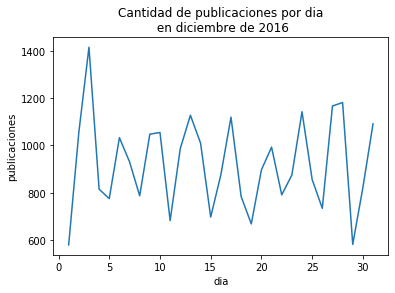

In [22]:
sns.lineplot(x = diciembre['dia'], y = diciembre['publicaciones'])
plt.title('Cantidad de publicaciones por dia\n en diciembre de 2016')
plt.savefig('./figs/diciembre_2016.png')

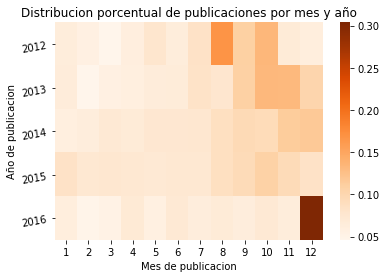

In [23]:
ax = sns.heatmap(fechas.T, cmap="Oranges")
ax.set_yticklabels(ax.get_yticklabels(), rotation=10)
plt.title("Distribucion porcentual de publicaciones por mes y año")
plt.xlabel("Mes de publicacion")
plt.ylabel("Año de publicacion")
ax.set_ylim(5.0, 0)
plt.savefig("figs/heatmap_fechas.png")
plt.show()